# 1D Plug Flow Reactor Model with Surface Chemistry
In this model, we will illustrate the derivation of the governing differential equations and algebraic constraints, calculation of the initial conditions of the variables and their spatial derivatives and use the IDA solver to solve this system of differential algebraic equations (DAE).

Requires the [scikits.odes.dae](http://scikits-odes.readthedocs.io/en/latest/guide.html#object-oriented-interface-ode-and-dae) solver. The easiest way to install this package is from the `conda-forge` channel using `conda`.

In [1]:
import numpy as np
from scikits.odes import dae
import cantera as ct

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

print(f"Runnning Cantera version: {ct.__version__}")

Runnning Cantera version: 2.6.0


## Define gas species, bulk species, surface species and the interface

In [2]:
# import the SiF4 + NH3 reaction mechanism
#mech = "../data/SiF4_NH3_mec.yaml"
mech = "multifacet_all.yaml"

# Import the models for gas-phase
gas = ct.Solution(mech, 'gas')

# input file containing the surface reaction mechanism
# import the (111) surface
surf = ct.Interface(mech,'surface2', [gas])

# Case 1: isothermal reactor
## Define reactor conditions : temperature, pressure, fuel, and some important parameters

In [3]:
T0 = 1020  # Kelvin
p0 = 1 * ct.one_atm 
gas.TPX = T0, p0, "CO:1"
surf.TP = T0, p0
surf.coverages = "site(211): 1.0, CO2(211): 2"
D = 5.08e-2  # diameter of the tube [m]
Ac = np.pi * D**2 / 4  # cross-section of the tube [m^2]
mu = 5.7e-5  # kg/(m-s) dynamic viscosity
perim = np.pi * D  # perimeter of the tube
# calculate the site fractions of surface species at the entrance of the tube at steady state
surf.advance_coverages(
    100000.0
)  # Here we assume after 100s, the system reaches the steady state
Zk_0 = surf.coverages
N = gas.n_species  # number of gas species
M = surf.n_species  # number of surface species

## Define a residual function for IDA solver

For the isothermal tube with laminar flow, since the temperature of the flow and tube is constant, the energy conservation equation can be ignored. The governing equations include conservation of mass and species, momentum equation, equation of state, and the algebraic constraints that the net production rate of surface species by heterogeneous reactions are zero and that the sum of site fractions equals 1.

Here we define a residual function, an equation which should always evaluate to the zero vector, as the input of IDA solver, which listed as follows:

\begin{align}
    R[0] &= u\frac{d\rho}{dz} + \rho\frac{du}{dz} - \frac{p'}{A_c}\sum^{K_g}\dot{s}_{k,g}W_{k,g} \\
    R[1] &= \rho u A_c\frac{dY_k}{dz} + Y_k p'\sum^{K_g}\dot{s}_{k,g}W_{k,g} - \dot{\omega_k}W_kA_c - \dot{s}_{k,g}W_{k,g} p' \\
    R[2] &= 2\rho u \frac{du}{dz} + u^2\frac{d\rho}{dz} + \frac{dP}{dz} + \frac{32u\mu}{D^2}\\
    R[3] &= P\bar{W} - \rho RT\\
    R[4] &= \dot{s}_{k,s} \\
    R[5] &= \sum_{phase}{Z_{k,s}} - 1
\end{align}     

The detailed derivation of the DAE system can be found in [my report](https://github.com/yuj056/yuj056.github.io/blob/master/Week1/yuj056_github_io.pdf).

In [4]:
def residual(z, vec, vecp, result):
    """we create the residual equations for the problem
    vec = [u, rho, Yk, p, Zk]
    vecp = [dudz, drhodz, dYkdz, dpdz, dZkdz]
    """
    # temporary variables
    u = vec[0]  # velocity
    rho = vec[1]  # density
    Y = vec[2 : 2 + N]  # vector of mass fractions of all gas species
    p = vec[2 + N]  # pressure
    Z = vec[3 + N :]  # vector of site fractions of all surface species

    dudz = vecp[0]  # velocity spatial derivative
    drhodz = vecp[1]  # density spatial derivative
    dYdz = vecp[2 : 2 + N]  # mass fraction spatial derivative
    dpdz = vecp[2 + N]  # pressure spatial derivative

    # Use unnormalized mass fractions to avoid over-constraining the system
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T0, p

    # Use unnormalized site fractions (coverages) to avoid over-constraining the system
    surf.set_unnormalized_coverages(Z)
    surf.TP = T0, p

    # temporary variables (based on the given state)
    coverages = surf.coverages  # site fraction vector
    sdot_g = surf.get_net_production_rates(
        "gas"
    )  # heterogeneous production rate of gas species
    sdot_s = surf.get_net_production_rates("surface2")
    wdot_g = gas.net_production_rates  # homogeneous production rate of gas species
    W_g = gas.molecular_weights  # vector of molecular weight of gas species

    # mass continuity equation
    result[0] = u * drhodz + rho * dudz - perim * np.sum(sdot_g * W_g) / Ac

    # conservation of species
    for k in range(N):
        result[1 + k] = (
            rho * u * Ac * dYdz[k]
            + Y[k] * perim * np.sum(sdot_g * W_g)
            - wdot_g[k] * W_g[k] * Ac
            - sdot_g[k] * W_g[k] * perim
        )
    # conservation of momentum
    result[1 + N] = (
        2 * rho * u * dudz + np.power(u, 2) * drhodz + dpdz + 32 * u * mu / D**2
    )

    # equation of state
    result[2 + N] = gas.density - rho

    # algebraic constraints
    for j in range(M):
        result[3 + N + j] = sdot_s[j]

    # replace the constraint with the condition sum(Zk) = 1 for the largest site fraction species
    index = np.argmax(coverages)
    result[3 + N + index] = np.sum(coverages) - 1

## Determine the initial values of the spatial derivatives of the unknowns which need to be used as the initial conditions for the IDA solver

The following linear equation system has been solved by [np.linalg.solve](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.solve.html), a linear solver, to calculate the initial values of the spatial derivatives of the unknowns.

\begin{align}
    u_0\rho_0' + \rho_0 u_0' - \frac{p'}{A_c}\sum^{K_g}\dot{s}_{k,g}W_{k,g} &= 0\\
    \rho_0 u_0 A_c Y_{k,0}' + Y_{k,0} p'\sum^{K_g}\dot{s}_{k,g}W_{k,g} - \dot{\omega_k}W_kA_c - \dot{s}_{k,g}W_{k,g} p' &=0 \\
    2\rho_0 u_0 u_0' + u_0^2\rho_0' + P_0' + \frac{32u_0 \mu}{D^2} &=0\\
    -RT\rho_0' + \bar{W_0}P_0' - P_0\frac{\sum^{K_g}Y_{k}'/W_{k,g}}{(\sum^{K_g}Y_{k}/W_{k,g})^2} &= 0
\end{align}

We assume the derivatives of the site fractions are equal to zero, although it is trivial for the IDA solver.

In [5]:
######## Solve linear system for the initial vecp ###########
#   a = coefficient of [u', rho', Yk', P']
#   b = RHS constant of each conservation equations
rho0 = gas.density  # initial density of the flow
u0 = 0.1  # m/s initial velocity of the flow
W = gas.molecular_weights
W_avg = gas.mean_molecular_weight
sdot_g = surf.get_net_production_rates(
    "gas"
)  # heterogeneous production rate of gas species
wdot = gas.net_production_rates  # homogeneous molar production rate
################### a #########################
a = np.zeros((3 + N, 3 + N))
a[0, :] = np.hstack((rho0, u0, np.zeros(1 + N)))
for i in range(N):
    a[1 + i, 2 + i] = rho0 * u0 * Ac
a[1 + N, :] = np.hstack((2 * rho0 * u0, u0**2, np.zeros(N), 1))
coef = np.zeros(N)
for j in range(N):
    coef[j] = gas.P / W[j] / np.power(np.sum(gas.Y / W), 2)
a[2 + N, :] = np.hstack((0, ct.gas_constant * T0, coef, -W_avg))
################### b ###########################
b = np.zeros(3 + gas.n_species)
b[0] = perim * np.sum(sdot_g[:N] * W) / Ac
for i in range(gas.n_species):
    b[1 + i] = (
        wdot[i] * W[i] * Ac
        + sdot_g[i] * W[i] * perim
        - gas.Y[i] * perim * np.sum(sdot_g[:N] * W)
    )
b[1 + gas.n_species] = -32 * u0 * mu / D**2
b[2 + gas.n_species] = 0
part_vecp0 = np.linalg.solve(a, b)

vecp0 = np.hstack((part_vecp0, np.zeros(M)))
vec0 = np.hstack((u0, gas.density, gas.Y, gas.P, Zk_0))

## Run the IDA solver to calculate the unknowns varying in the flow direction

In [6]:
solver = dae(
    "ida",
    residual,
    first_step_size=1e-16,
    atol=1e-8,  # absolute tolerance for solution
    rtol=1e-8,  # relative tolerance for solution
    # If the given problem is of type DAE, some items of the residual vector
    # returned by the 'resfn' have to be treated as algebraic equations, and
    # algebraic variables must be defined. These algebraic variables are
    # denoted by the position (index) in the state vector y. All these
    # indexes have to be specified in the 'algebraic_vars_idx' array.
    algebraic_vars_idx=[np.arange(3 + N, 3 + N + M, 1)],
    max_steps=5000,
    old_api=False,  # Forces use of new api (namedtuple)
)

times = np.arange(0, 0.7, 0.01)
solution = solver.solve(times, vec0, vecp0)
print(solution)

SolverReturn(flag=-4, values=SolverVariables(t=array([0.]), y=array([[1.00000000e-01, 3.34653495e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.01325000e+05, 9.92100722e-04, 2.24894549e-10, 3.86107943e-04,
        9.98621791e-01, 5.68047792e-17, 0.00000000e+00]]), ydot=array([[ 6.97551671e-08, -2.33437571e-07,  1.25945722e-15,
         2.86820077e-16,  2.39451148e-11, -3.16646288e-16,
        -2.39451148e-11,  0.00000000e+00, -7.06801437e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])), errors=SolverVariables(t=0.0, y=array([1.00000000e-01, 3.34653495e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.01325000e+05, 9.92100722e-04, 2.24894549e-10, 3.86107943e-04,
       9.98621791e-01, 5.68047792e-17, 0.00000000e+00]), ydot=array([ 6.97551671e-08, -2.33437571e-07,  1.25945722

## Plot the results

ValueError: x and y must have same first dimension, but have shapes (70,) and (1,)

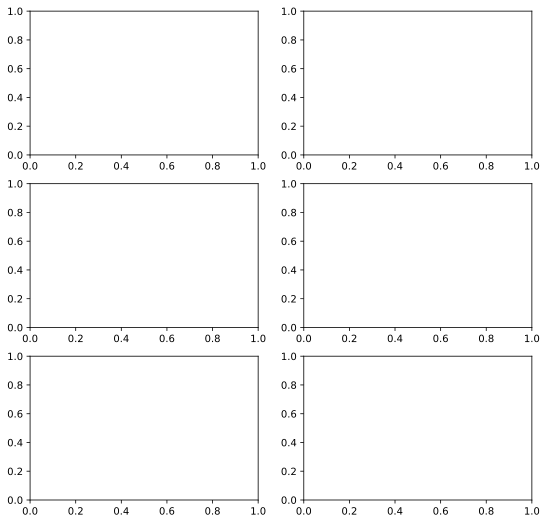

In [7]:
# plot velocity of gas along the flow direction
f, ax = plt.subplots(3, 2, figsize=(9, 9))
ax[0, 0].plot(times, solution.values.y[:, 0], color="C0")
ax[0, 0].set_xlabel("Distance (m)")
ax[0, 0].set_ylabel("Velocity (m/s)")

# plot gas density along the flow direction
ax[0, 1].plot(times, solution.values.y[:, 1], color="C1")
ax[0, 1].set_xlabel("Distance (m)")
ax[0, 1].set_ylabel(r"Density ($\mathregular{kg/m^3}$)")
ax[0, 1].ticklabel_format(
    axis="y", style="sci", scilimits=(-2, 2)
)  # scientific notation

# plot major and minor gas species separately
minor_idx = []
major_idx = []
for i, name in enumerate(gas.species_names):
    mean = np.mean(solution.values.y[:, 2 + i])
    if mean <= 0.01:
        minor_idx.append(i)
    else:
        major_idx.append(i)

# plot minor species
for i in minor_idx:
    style = "-" if i < 10 else "--"
    ax[1, 0].plot(
        times, solution.values.y[:, 2 + i], label=gas.species_names[i], linestyle=style
    )
ax[1, 0].legend(fontsize=7, loc="upper right")
ax[1, 0].set_xlabel("Distance (m)")
ax[1, 0].set_ylabel("Mass Fraction")
ax[1, 0].ticklabel_format(
    axis="y", style="sci", scilimits=(-2, 2)
)  # scientific notation

# plot major species
for j in major_idx:
    ax[1, 1].plot(times, solution.values.y[:, 2 + j], label=gas.species_names[j])
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel("Distance (m)")
ax[1, 1].set_ylabel("Mass Fraction")

# plot the pressure of the gas along the flow direction
ax[2, 0].plot(times, solution.values.y[:, 2 + N], color="C2")
ax[2, 0].set_xlabel("Distance (m)")
ax[2, 0].set_ylabel("Pressure (Pa)")

# plot the site fraction of the surface species along the flow direction
for i, name in enumerate(surf.species_names):
    ax[2, 1].plot(times, solution.values.y[:, 3 + N + i], label=name)
ax[2, 1].legend()
ax[2, 1].set_xlabel("Distance (m)")
ax[2, 1].set_ylabel("Site Fraction")
f.tight_layout(pad=0.5)